In [190]:
import sys
sys.path.append('../Utilities/')

from tqdm.notebook import tqdm
import numpy as np

import importlib
import data_utils
importlib.reload(data_utils)

<module 'data_utils' from 'd:\\LMU\\Computer Vision & DL\\Project\\ComputerVision_CloudSegmentation\\Post hoc correction\\../Utilities\\data_utils.py'>

In [2]:
patches,mask = data_utils.get_patch(path_to_folders_images = "../Dataset/Natural_False_Color/", path_to_folders_labels = "../Dataset/Entire_scene_gts/")

c:\Users\Chaitanya Ashtekar\AppData\Local\Programs\Python\Python39\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [3]:
np.random.seed(42)
test_index = np.random.choice(range(len(patches)), size=200, replace=False)

In [5]:
predictions = np.load("prediction_maps.npy")
ground_truth_maps = np.load("ground_truth_maps.npy")

In [6]:
predictions = predictions.astype("int64")

In [7]:
index = 52

In [8]:
properties_df, slic_frame = data_utils.fast_image_to_slic(patches[test_index[index]],predictions[index],n_segments=1000) 

In [191]:
## Write a function to calculate the dice score between two images
def get_jaccard_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    jaccard = np.sum(intersection) / np.sum(union)
    return jaccard

def get_dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice = 2 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

In [121]:
# Approach 1: Use Mahalanobis distance to filter out outlier predictions.

data = properties
features = np.array([[d['num_pixels'], *d['color'], d['centroid_x'], d['centroid_y']] for d in data if d["label"] == 0])

# Calculate mean and covariance matrix of features
mean_features = np.mean(features, axis=0)
cov_matrix_features = np.cov(features, rowvar=False)
inv_cov_matrix_features = np.linalg.inv(cov_matrix_features)

# Calculate Mahalanobis distance for each feature vector
mahalanobis_distances = []
for feature in features:
    mahalanobis_dist = distance.mahalanobis(feature, mean_features, inv_cov_matrix_features)
    mahalanobis_distances.append(mahalanobis_dist)

# Set the significance level for outlier detection (e.g., 0.05)
alpha = 0.05

# Calculate the chi-squared threshold for the given significance level and feature dimensions
df = len(mean_features)
chi2_threshold = chi2.ppf(1 - alpha, df)

# Identify outliers based on Mahalanobis distances and update their labels
outlier_indices = [i for i, distance in enumerate(mahalanobis_distances) if distance > np.sqrt(chi2_threshold)]

converted_count = 0
for i in outlier_indices:
    data[i]['label'] = 1
    converted_count +=1


print("Updated data with outlier labels:", data)
print(f"Converted count: {converted_count}")

Updated data with outlier labels: [{'superpixel_num': 1, 'color': array([119.4962406 , 127.91353383, 111.57142857]), 'centroid_x': 15.657894736842104, 'centroid_y': 5.518796992481203, 'num_pixels': 266, 'label': 0}
 {'superpixel_num': 2, 'color': array([157.45637584, 170.01006711, 155.79865772]), 'centroid_x': 16.55704697986577, 'centroid_y': 11.506711409395972, 'num_pixels': 298, 'label': 0}
 {'superpixel_num': 3, 'color': array([179.78305085, 200.78983051, 186.39322034]), 'centroid_x': 4.240677966101695, 'centroid_y': 27.044067796610168, 'num_pixels': 295, 'label': 0}
 {'superpixel_num': 4, 'color': array([119.59473684, 132.96315789, 115.5       ]), 'centroid_x': 10.094736842105263, 'centroid_y': 40.83684210526316, 'num_pixels': 190, 'label': 0}
 {'superpixel_num': 5, 'color': array([60.90277778, 81.54166667, 55.9375    ]), 'centroid_x': 6.166666666666667, 'centroid_y': 58.77777777777778, 'num_pixels': 288, 'label': 1}
 {'superpixel_num': 6, 'color': array([ 75.61276596, 101.85957447

In [18]:
from skimage.color import rgb2lab
import numpy as np

# Calculate CIELAB difference (Delta E) between two colors
def calculate_color_similarity(color1, color2):
    lab_color1 = rgb2lab(color1.reshape(1, -1, 1), channel_axis=1)
    lab_color2 = rgb2lab(color2.reshape(1, -1, 1), channel_axis=1)
    delta_e = np.linalg.norm(lab_color1 - lab_color2)
    return delta_e

In [19]:
def rgb_to_lab(rgb):
    r, g, b = rgb
    r = np.asarray(r)
    g = np.asarray(g)
    b = np.asarray(b)
    r /= 255.0
    g /= 255.0
    b /= 255.0
    r = np.where(r > 0.04045, ((r + 0.055) / 1.055) ** 2.4, r / 12.92)
    g = np.where(g > 0.04045, ((g + 0.055) / 1.055) ** 2.4, g / 12.92)
    b = np.where(b > 0.04045, ((b + 0.055) / 1.055) ** 2.4, b / 12.92)
    r = r * 100
    g = g * 100
    b = b * 100
    X = r * 0.4124564 + g * 0.3575761 + b * 0.1804375
    Y = r * 0.2126729 + g * 0.7151522 + b * 0.0721750
    Z = r * 0.0193339 + g * 0.1191920 + b * 0.9503041
    X = X / 95.047
    Y = Y / 100.000
    Z = Z / 108.883
    X = np.where(X > 0.008856, X ** (1/3), (903.3 * X + 16) / 116)
    Y = np.where(Y > 0.008856, Y ** (1/3), (903.3 * Y + 16) / 116)
    Z = np.where(Z > 0.008856, Z ** (1/3), (903.3 * Z + 16) / 116)
    L = (116 * Y) - 16
    a = 500 * (X - Y)
    b = 200 * (Y - Z)
    return L, a, b

    
def calculate_color_similarity(color1, color2):
    if color2.ndim == 1:
        # If color2 is a single color array
        L1, a1, b1 = rgb_to_lab(color1)
        L2, a2, b2 = rgb_to_lab(color2)
        delta_E = np.sqrt((L2 - L1) ** 2 + (a2 - a1) ** 2 + (b2 - b1) ** 2)
    else:
        # If color2 is an array of color arrays
        L1, a1, b1 = rgb_to_lab(color1)
        L2, a2, b2 = rgb_to_lab(color2.T)
        delta_E = np.sqrt((L2 - L1) ** 2 + (a2 - a1) ** 2 + (b2 - b1) ** 2)
    return delta_E

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate cosine similarity between two vectors
def calculate_cosine_similarity(vector1, vector2):
    cosine_sim = cosine_similarity(vector1, vector2)
    return cosine_sim

In [288]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean

# Approach 2: Use color similarity metric for calculating the similarity between RGB values and use Euclidean distances(or any other numeric distance) to get distance for other two attributes(centroids, num_pixels). Overall similarity is the weighted combination of these.

# Separate superpixels based on their labels (0 or 1)
superpixels_0 = properties_df[properties_df['labels'] == 0]
superpixels_1 = properties_df[properties_df['labels'] == 1]

# # Define a function to calculate Euclidean distance
def calculate_euclidean_distance(vec1, vec2):
    return euclidean(vec1, vec2)

def vectorized_euclidean_distance(point1, points):
    return np.sqrt(np.sum((points - point1)**2, axis=1))

def vectorized_compare_to_centroids(centroid, centroid_list):
    centroid_set = np.array(centroid_list)
    distances = vectorized_euclidean_distance(centroid, centroid_set)
    return distances

def custom_range_normalize(value, min_val, max_val):
    normalized_value = (value - min_val) / (max_val - min_val)
    return normalized_value

# Define the custom ranges for each metric
pixel_distance_min = 0
pixel_distance_max = 5000

color_similarity_min = 0
color_similarity_max = 200

centroid_distance_min = 0
centroid_distance_max = 200

converted_count = 0
similarity_threshold = 0.75 #Hyperparameter. Need to find a way to smartly set this value

weight_feature1 = 0.5
weight_feature2 = -0.2# Negative weight since larger euclidean distance indicates lower similarity. Hyperparameter again.
weight_feature3 = -0.3 # same reason as above
similarity_scores = []

In [274]:
for idx, superpixel_1 in superpixels_1.iterrows():
    color1 = superpixel_1[['R', 'G', 'B']].values
    color2 = superpixels_0[['R', 'G', 'B']].values
    color_similarity = calculate_color_similarity(color1, color2)
    
    pixel_distance = vectorized_euclidean_distance(np.array([superpixel_1['num_pixels']]).reshape(-1,1), superpixels_0['num_pixels'].values)
    centroid_distance = vectorized_compare_to_centroids(superpixel_1[['x', 'y']].values, superpixels_0[['x', 'y']].values)

    #Get aggregated values for all metrics
    mean_color_similarity = np.mean(color_similarity)
    pixel_distance = pixel_distance[0]
    mean_centroid_distance = np.mean(centroid_distance)

    normalized_pixel_distance = custom_range_normalize(pixel_distance, pixel_distance_min, pixel_distance_max)
    normalized_color_similarity = custom_range_normalize(mean_color_similarity, color_similarity_min, color_similarity_max)
    normalized_centroid_distance = custom_range_normalize(mean_centroid_distance, centroid_distance_min, centroid_distance_max)

    # # Calculate overall normalized distance using weighted combination
    overall_similarity_score = np.abs((weight_feature1 * normalized_color_similarity) + (weight_feature2 * normalized_pixel_distance) + (weight_feature3 * normalized_centroid_distance))
    similarity_scores.append(overall_similarity_score)

    if overall_similarity_score > similarity_threshold:
        properties_df.at[idx, "labels"] = 0
        converted_count+=1


print("Converted count: ",converted_count)
labels = properties_df["labels"].to_list()
after_post_hoc_op = data_utils.reverse_segmentation(slic_frame, labels)


Converted count:  6


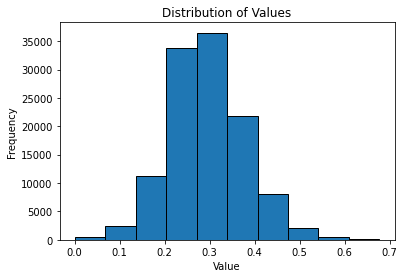

In [282]:
import numpy as np
import matplotlib.pyplot as plt

# Example array
data = np.array(similarity_scores)

# Create a histogram
plt.hist(data, bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values')

# Display the plot
plt.show()


In [125]:
labels = properties_df["labels"].to_list()

In [126]:
after_post_hoc_op = data_utils.reverse_segmentation(slic_frame, labels)

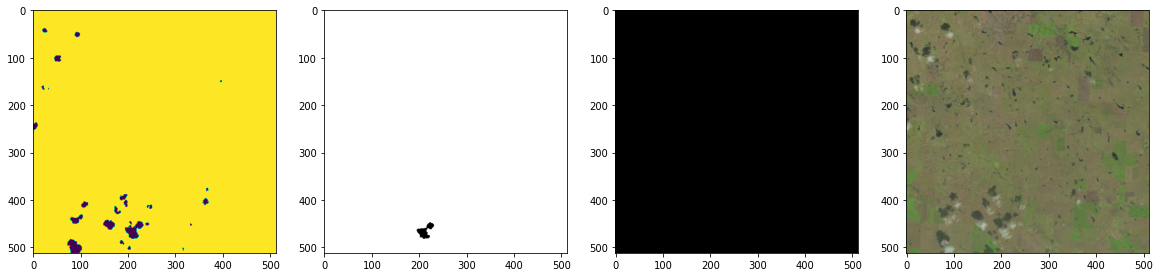

In [281]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(ground_truth_maps[index])
plt.subplot(1,4,2)
plt.imshow(predictions[index],cmap='gray')
plt.subplot(1,4,3)
plt.imshow(after_post_hoc_op, cmap='gray')
plt.subplot(1,4,4)
plt.imshow(patches[test_index[index]])

In [277]:
get_dice_score(ground_truth_maps[index], predictions[index])

0.9948721889739575

In [278]:
get_dice_score(ground_truth_maps[index], after_post_hoc_op)

0.9915517287916004

In [289]:
converted_count = 0
how_many_times_converted_count_zero = 0
dice_scores_without_correction = []
dice_scores_with_correction = []
dice_scores_when_count_0 = []
similarity_scores = []

for id, gt in enumerate(ground_truth_maps):
    patch = patches[test_index[id]]
    prediction = predictions[id]

    properties_df, slic_frame = data_utils.fast_image_to_slic(patch,prediction,n_segments=1000) 
    
    # Separate superpixels based on their labels (0 or 1)
    superpixels_0 = properties_df[properties_df['labels'] == 0]
    superpixels_1 = properties_df[properties_df['labels'] == 1]

    
    for idx, superpixel_1 in superpixels_1.iterrows():
        color1 = superpixel_1[['R', 'G', 'B']].values
        color2 = superpixels_0[['R', 'G', 'B']].values
        color_similarity = calculate_color_similarity(color1, color2)
        
        pixel_distance = vectorized_euclidean_distance(np.array([superpixel_1['num_pixels']]).reshape(-1,1), superpixels_0['num_pixels'].values)
        centroid_distance = vectorized_compare_to_centroids(superpixel_1[['x', 'y']].values, superpixels_0[['x', 'y']].values)

        #Get aggregated values for all metrics
        mean_color_similarity = np.mean(color_similarity)
        pixel_distance = pixel_distance[0]
        mean_centroid_distance = np.mean(centroid_distance)

        normalized_pixel_distance = custom_range_normalize(pixel_distance, pixel_distance_min, pixel_distance_max)
        normalized_color_similarity = custom_range_normalize(mean_color_similarity, color_similarity_min, color_similarity_max)
        normalized_centroid_distance = custom_range_normalize(mean_centroid_distance, centroid_distance_min, centroid_distance_max)

        # # Calculate overall normalized distance using weighted combination
        overall_similarity_score = np.abs((weight_feature1 * normalized_color_similarity) + (weight_feature2 * normalized_pixel_distance) + (weight_feature3 * normalized_centroid_distance))
        similarity_scores.append(overall_similarity_score)
    
        if overall_similarity_score > similarity_threshold:
            properties_df.at[idx, "labels"] = 0
            converted_count+=1

    labels = properties_df["labels"].to_list()
    after_post_hoc_op = data_utils.reverse_segmentation(slic_frame, labels)

    if converted_count == 0:
        how_many_times_converted_count_zero+=1
        dice_scores_when_count_0.append((get_dice_score(gt, prediction), get_dice_score(gt, after_post_hoc_op)))
        dice_scores_without_correction.append(get_dice_score(gt, prediction))
        dice_scores_with_correction.append(get_dice_score(gt, prediction))
    else:
        dice_scores_without_correction.append(get_dice_score(gt, prediction))
        dice_scores_with_correction.append(get_dice_score(gt, after_post_hoc_op))



    
print(f"How many times converted count 0: {how_many_times_converted_count_zero}/200")
print("Average dice score without correction: ", np.mean(np.array(dice_scores_without_correction)))
print("Average dice score with correction: ", np.mean(np.array(dice_scores_with_correction)))

How many times converted count 0: 0/200
Average dice score without correction:  0.8572865840921539
Average dice score with correction:  0.8516980116839534


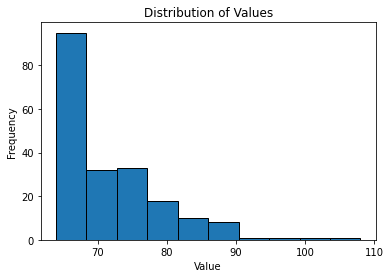

In [293]:
import numpy as np
import matplotlib.pyplot as plt

# Example array
data = np.array(pixel_range)

# Create a histogram
plt.hist(data, bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values')

# Display the plot
plt.show()

In [10]:
superpixels_df = properties_df

In [192]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# Set a threshold for the size of small superpixels
size_threshold_small = 90

size_threshold_large = 200

In [165]:
index = 40

In [159]:
properties_df, slic_frame = data_utils.fast_image_to_slic(patches[test_index[index]],predictions[index],n_segments=1000) 

In [166]:
superpixels_df = properties_df

In [167]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

#Approach 3: Seperate data based on two groups(small superpixel and large superpixel). Calculate color and centroid similairty between these two groups.

# Set a threshold for the size of small superpixels

quantiles = superpixels_df["num_pixels"].quantile([0.25, 0.5, 0.75])

# Set thresholds based on quantiles
size_threshold_lower = quantiles[0.25]
size_threshold_upper = quantiles[0.75]

# Set a threshold for color similarity
color_similarity_threshold = 0.6 # Adjust as needed

# Create a copy of the DataFrame to track changes
modified_superpixels_df = superpixels_df.copy()

# Extract small superpixels
small_superpixels = superpixels_df[superpixels_df["labels"] == 1][superpixels_df["num_pixels"] < size_threshold_lower]


# Extract large superpixels
large_superpixels = superpixels_df[superpixels_df["labels"] == 0][superpixels_df["num_pixels"] > size_threshold_upper]

# Calculate Euclidean distances between small and large superpixels
distances = cdist(small_superpixels[["x", "y"]], large_superpixels[["x", "y"]])

# Calculate color similarities between small and large superpixels
color_similarities = np.exp(-cdist(small_superpixels[["R", "G", "B"]],
                                   large_superpixels[["R", "G", "B"]]) / 255)

# Find the nearest larger superpixel for each small superpixel
nearest_indices = np.argmin(distances, axis=1)


# Find the color similarity for the nearest larger superpixel
nearest_color_similarities = color_similarities[np.arange(len(nearest_indices)), nearest_indices]

# Perform merging based on color similarity
merge_indices = nearest_color_similarities > color_similarity_threshold

# Update labels for merged small superpixels
modified_superpixels_df.loc[small_superpixels[merge_indices].index, "labels"] = 0

# Count the number of labels changed
count_labels_changed = (modified_superpixels_df["labels"] != superpixels_df["labels"]).sum()

print("Count of labels changed:", count_labels_changed)


               x           y           R           G           B  labels  \
slic                                                                       
10    181.176768    5.858586  137.757576  145.424242  124.989899       1   
30    122.043689   18.936893  151.626214  166.791262  144.067961       1   
41    155.198925   19.526882  122.166667  132.397849  106.666667       1   
221   190.326531  113.061224  120.857143  138.789116  110.231293       1   
263     5.506410  139.666667  129.038462  126.198718  106.532051       1   
300   122.222798  154.818653  149.264249  155.492228  132.150259       1   
310   201.721591  159.647727  106.761364  115.346591   84.647727       1   
380   294.872449  200.270408  110.469388  112.709184   84.403061       1   
410   296.989950  214.492462  116.738693  120.447236   91.386935       1   
428   311.326733  225.014851  110.534653  112.440594   88.089109       1   
450   271.168605  239.546512  126.877907  126.156977   80.784884       1   
468   449.05

C:\Users\CHAITA~1\AppData\Local\Temp/ipykernel_23784/1805083253.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  small_superpixels = superpixels_df[superpixels_df["labels"] == 1][superpixels_df["num_pixels"] < size_threshold_lower]
C:\Users\CHAITA~1\AppData\Local\Temp/ipykernel_23784/1805083253.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  large_superpixels = superpixels_df[superpixels_df["labels"] == 0][superpixels_df["num_pixels"] > size_threshold_upper]


In [168]:
labels = modified_superpixels_df["labels"].to_list()

In [169]:
after_post_hoc_op = data_utils.reverse_segmentation(slic_frame, labels)

In [170]:
get_dice_score(ground_truth_maps[index], predictions[index])

0.5953886961844521

In [171]:
get_dice_score(ground_truth_maps[index], after_post_hoc_op)

0.555127445168939

In [399]:
dice_scores_without_correction = []
dice_scores_with_correction = []

for id, gt in enumerate(ground_truth_maps):
    patch = patches[test_index[id]]
    prediction = predictions[id]

    superpixels_df, slic_frame = data_utils.fast_image_to_slic(patch,prediction,n_segments=1000)

    # Extract small superpixels
    small_superpixels = superpixels_df[superpixels_df["labels"] == 1][superpixels_df["num_pixels"] < size_threshold_small]

    # Extract large superpixels
    large_superpixels = superpixels_df[superpixels_df["labels"] == 0][superpixels_df["num_pixels"] > size_threshold_large]

    # Calculate Euclidean distances between small and large superpixels
    distances = cdist(small_superpixels[["x", "y"]], large_superpixels[["x", "y"]])

    if not small_superpixels.empty and not large_superpixels.empty:
        nearest_indices = np.argmin(distances, axis=1)
        superpixels_df.loc[nearest_indices, "labels"] = 0
        labels = superpixels_df["labels"].to_list()
        after_post_hoc_op = data_utils.reverse_segmentation(slic_frame, labels)
        dice_scores_without_correction.append(get_dice_score(gt, prediction))
        dice_scores_with_correction.append(get_dice_score(gt, after_post_hoc_op))
    else:
        dice_scores_without_correction.append(get_dice_score(gt, prediction))
        dice_scores_with_correction.append(get_dice_score(gt, prediction))
        print("No merging operations needed.")


print("Average dice score without correction: ", np.mean(np.array(dice_scores_without_correction)))
print("Average dice score with correction: ", np.mean(np.array(dice_scores_with_correction)))

C:\Users\CHAITA~1\AppData\Local\Temp/ipykernel_15604/3291277934.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  small_superpixels = superpixels_df[superpixels_df["labels"] == 1][superpixels_df["num_pixels"] < size_threshold_small]
C:\Users\CHAITA~1\AppData\Local\Temp/ipykernel_15604/3291277934.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  large_superpixels = superpixels_df[superpixels_df["labels"] == 0][superpixels_df["num_pixels"] > size_threshold_large]


No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging

In [183]:
dice_scores_without_correction = []
dice_scores_with_correction = []
jaccard_scores_without_correction = []
jaccard_scores_with_correction = []

for id, gt in enumerate(ground_truth_maps):
    patch = patches[test_index[id]]
    prediction = predictions[id]

    superpixels_df, slic_frame = data_utils.fast_image_to_slic(patch,prediction,n_segments=1000)

    # Extract small superpixels
    small_superpixels = superpixels_df[superpixels_df["labels"] == 1][superpixels_df["num_pixels"] < size_threshold_small]

    # Extract large superpixels
    large_superpixels = superpixels_df[superpixels_df["labels"] == 0][superpixels_df["num_pixels"] > size_threshold_large]

    if not small_superpixels.empty and not large_superpixels.empty:
        distances = cdist(small_superpixels[["x", "y"]], large_superpixels[["x", "y"]])

        # Calculate color similarities between small and large superpixels
        color_similarities = np.exp(-cdist(small_superpixels[["R", "G", "B"]],
                                   large_superpixels[["R", "G", "B"]]) / 255)

        # Find the nearest larger superpixel for each small superpixel
        nearest_indices = np.argmin(distances, axis=1)

        # Find the color similarity for the nearest larger superpixel
        nearest_color_similarities = color_similarities[np.arange(len(nearest_indices)), nearest_indices]

        # Perform merging based on color similarity
        merge_indices = nearest_color_similarities > color_similarity_threshold

        # Update labels for merged small superpixels
        superpixels_df.loc[small_superpixels[merge_indices].index, "labels"] = 0

        labels = superpixels_df["labels"].to_list()
        after_post_hoc_op = data_utils.reverse_segmentation(slic_frame, labels)
        dice_scores_without_correction.append(get_dice_score(gt, prediction))
        dice_scores_with_correction.append(get_dice_score(gt, after_post_hoc_op))
        jaccard_scores_with_correction.append(get_jaccard_score(gt, after_post_hoc_op))
        jaccard_scores_without_correction.append(get_jaccard_score(gt,prediction))
    else:
        dice_scores_without_correction.append(get_dice_score(gt, prediction))
        dice_scores_with_correction.append(get_dice_score(gt, prediction))
        jaccard_scores_with_correction.append(get_jaccard_score(gt, prediction))
        jaccard_scores_without_correction.append(get_jaccard_score(gt,prediction))
        print("No merging operations needed.")


print("Average dice score without correction: ", np.mean(np.array(dice_scores_without_correction)))
print("Average dice score with correction: ", np.mean(np.array(dice_scores_with_correction)))
print("Average jaccard score with correction: ", np.mean(np.array(jaccard_scores_with_correction)))
print("Average jaccard score without correction: ", np.mean(np.array(jaccard_scores_without_correction)))

C:\Users\CHAITA~1\AppData\Local\Temp/ipykernel_23784/3150966202.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  small_superpixels = superpixels_df[superpixels_df["labels"] == 1][superpixels_df["num_pixels"] < size_threshold_small]
C:\Users\CHAITA~1\AppData\Local\Temp/ipykernel_23784/3150966202.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  large_superpixels = superpixels_df[superpixels_df["labels"] == 0][superpixels_df["num_pixels"] > size_threshold_large]


No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging

In [189]:
dice_scores_without_correction = []
dice_scores_with_correction = []
jaccard_scores_without_correction = []
jaccard_scores_with_correction = []

#Approach 4: Check for two way correction(0 to 1 and again 1 to 0)

for id, gt in enumerate(ground_truth_maps):
    patch = patches[test_index[id]]
    prediction = predictions[id]

    superpixels_df, slic_frame = data_utils.fast_image_to_slic(patch,prediction,n_segments=1000)

    # Extract small superpixels
    small_superpixels = superpixels_df[superpixels_df["labels"] == 1][superpixels_df["num_pixels"] < size_threshold_small]

    # Extract large superpixels
    large_superpixels = superpixels_df[superpixels_df["labels"] == 0][superpixels_df["num_pixels"] > size_threshold_large]

    if not small_superpixels.empty and not large_superpixels.empty:
        distances = cdist(small_superpixels[["x", "y"]], large_superpixels[["x", "y"]])

        # Calculate color similarities between small and large superpixels
        color_similarities = np.exp(-cdist(small_superpixels[["R", "G", "B"]],
                                   large_superpixels[["R", "G", "B"]]) / 255)

        # Find the nearest larger superpixel for each small superpixel
        nearest_indices = np.argmin(distances, axis=1)

        # Find the color similarity for the nearest larger superpixel
        nearest_color_similarities = color_similarities[np.arange(len(nearest_indices)), nearest_indices]

        # Perform merging based on size and color similarity
        merge_indices_small_to_large = (nearest_color_similarities > color_similarity_threshold) & (small_superpixels["num_pixels"] < size_threshold_small)
        superpixels_df.loc[small_superpixels[merge_indices_small_to_large].index, "labels"] = 0
        #superpixels_df.loc[small_superpixels[merge_indices_small_to_large].index, "num_pixels"] += large_superpixels.loc[nearest_indices[merge_indices_small_to_large], "num_pixels"].values

        # Find the nearest smaller superpixel for each large superpixel
        distances_large_to_small = cdist(large_superpixels[["x", "y"]], small_superpixels[["x", "y"]])
        nearest_indices_large_to_small = np.argmin(distances_large_to_small, axis=1)

        # Find the color similarity for the nearest smaller superpixel
        nearest_color_similarities_large_to_small = color_similarities[nearest_indices_large_to_small, np.arange(len(large_superpixels))]

        # Perform merging based on size and color similarity (large to small)
        merge_indices_large_to_small = (nearest_color_similarities_large_to_small > color_similarity_threshold) & (large_superpixels["num_pixels"] > size_threshold_large)
        superpixels_df.loc[large_superpixels[merge_indices_large_to_small].index, "labels"] = 1
        #superpixels_df.loc[large_superpixels[merge_indices_large_to_small].index, "num_pixels"] += small_superpixels.loc[nearest_indices_large_to_small[merge_indices_large_to_small], "num_pixels"].values

        
        labels = superpixels_df["labels"].to_list()
        after_post_hoc_op = data_utils.reverse_segmentation(slic_frame, labels)
        dice_scores_without_correction.append(get_dice_score(gt, prediction))
        dice_scores_with_correction.append(get_dice_score(gt, after_post_hoc_op))
        jaccard_scores_with_correction.append(get_jaccard_score(gt, after_post_hoc_op))
        jaccard_scores_without_correction.append(get_jaccard_score(gt,prediction))
    else:
        dice_scores_without_correction.append(get_dice_score(gt, prediction))
        dice_scores_with_correction.append(get_dice_score(gt, prediction))
        jaccard_scores_with_correction.append(get_jaccard_score(gt, prediction))
        jaccard_scores_without_correction.append(get_jaccard_score(gt,prediction))
        print("No merging operations needed.")


print("Average dice score without correction: ", np.mean(np.array(dice_scores_without_correction)))
print("Average dice score with correction: ", np.mean(np.array(dice_scores_with_correction)))
print("Average jaccard score with correction: ", np.mean(np.array(jaccard_scores_with_correction)))
print("Average jaccard score without correction: ", np.mean(np.array(jaccard_scores_without_correction)))

C:\Users\CHAITA~1\AppData\Local\Temp/ipykernel_23784/570490865.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  small_superpixels = superpixels_df[superpixels_df["labels"] == 1][superpixels_df["num_pixels"] < size_threshold_small]
C:\Users\CHAITA~1\AppData\Local\Temp/ipykernel_23784/570490865.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  large_superpixels = superpixels_df[superpixels_df["labels"] == 0][superpixels_df["num_pixels"] > size_threshold_large]


No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging operations needed.
No merging